# d phi visualization

This notebook includes mds and d phi computation and visualization.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.markers as markers
from matplotlib.lines import Line2D
from mpl_toolkits import mplot3d
import seaborn as sns; sns.set()
from scipy.spatial.transform import Rotation as Rot
import numpy as np
import math
import copy
import yaml
import sys
import colorsys as csys

import sklearn
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
# from mpl_toolkits import mplot3d
from points_registration import points_registration

In [86]:
#filenames = ['0112_1000', '0112_1031', '0112_1153', '0112_1305' ,'0112_1328']
filenames = ['0112_1153']
guid_path = [0x6a7d, 0x6a4b, 0x6a20, 0x6a46, 0x6755]
guid_len = [18.95, 22.49, 10.06, 10.2]
guid_anchor_pos = [[0, -0.92], [18.95, -0.92], [41.44, -0.92], [51.04, 2.08], [61.24, 2.08]]
stick_l = 0.82
r_tag_points = np.array([[-0.65, 0.0],[0.12, 0.13]])

color_met ={}
cnt = 0
for name in filenames:
    rgb = csys.hsv_to_rgb(float(cnt)/len(filenames), 1, 1)
    color_met[name] = rgb
    cnt+=1

msize = 8
patch_1 = Line2D([0], [0], linestyle='-', color=[0.95, 0.95, 0], label='Raw d', linewidth=msize)
patch_2 = Line2D([0], [0], linestyle='-', color=[1, 0.5, 0.], label='Filtered d', linewidth=msize)
patch_3 = Line2D([0], [0], linestyle='-', color=[1, 0., 0.], label='GT(SLAM) d', linewidth=msize)
patch_4 = Line2D([0], [0], linestyle='-', color=[0.3, 0.3, 0.3], label='UWB Beacons', linewidth=msize)
patches_1 = [patch_1, patch_2, patch_3, patch_4]
patch_5 = Line2D([0], [0], linestyle='-', color=[0.95, 0, 0.95], label=r'Raw $\Phi$', linewidth=msize)
patch_6 = Line2D([0], [0], linestyle='-', color=[0., 0.8, 0.8], label=r'Filtered $\Phi$', linewidth=msize)
patch_7 = Line2D([0], [0], linestyle='-', color=[0, 0, 0.8], label=r'GT(SLAM) $\Phi$', linewidth=msize)
patches_2 = [patch_5, patch_6, patch_7, patch_4]

def ax_init_d(ax, color):
    # ax.set_facecolor((1.0, 1.0, 1.0))
    # axes[0].axis('equal')
    ax.set_aspect('auto')
    #ax.set_xbound(lower=-10, upper=5)
    #ax.set_ybound(lower=-2, upper=65)
    #ax.set_xticks(ticks=ax.get_xticks())
    #ax.set_xticklabels(-1*ax.get_xticks())
    ax.tick_params(axis='x',labelsize=25)
    ax.tick_params(axis='y',labelsize=25, color=color)
    ax.legend(handles=patches_1, fontsize=20)
    #ax.set_xlabel('Timestamp (sec)', fontsize=20)
    ax.set_ylabel('d (meter)', fontsize=25, color=color)
    ax.grid(color=[0.3, 0.3, 0.3], linestyle='-', linewidth=2)
    return ax
def ax_init_phi(ax, color):
    # ax.set_facecolor((1.0, 1.0, 1.0))
    # axes[0].axis('equal')
    ax.set_aspect('auto')
    #ax.set_xbound(lower=-10, upper=5)
    #ax.set_ybound(lower=-2, upper=65)
    #ax.set_xticks(ticks=ax.get_xticks())
    #ax.set_xticklabels(-1*ax.get_xticks())
    ax.tick_params(axis='x',labelsize=25)
    ax.tick_params(axis='y',labelsize=25, color=color)
    ax.legend(handles=patches_2, fontsize=20)
    ax.set_ylabel('phi (degree)', fontsize=25, color=color)
    ax.set_xlabel('Timestamp (sec)', fontsize=25)
    ax.grid(color=[0.3, 0.3, 0.3], linestyle='-', linewidth=2)
    return ax

In [3]:
def check_flip(out, left=True):
    # we assume the robot is always on the left of the lane

    rb = out[-4]
    rf = out[-3]
    mid = rb+rf/2
    
    lb = out[-2]
    lf = out[-1]

    '''
    if lf[1]==lb[1]:
        if (lf[0]-lf[1])*(rf[1]-lf[1]) < 0:
            return True if left else False
        if (lf[0]-lf[1])*(rb[1]-lb[1]) < 0:
            return True if left else False
        return False if left else True

    if lf[0]!=lb[0]:
        slope,c = np.polyfit([lb[0],lf[0]],[lb[1],lf[1]],1)
        pbx = 1.*(-1*c + rb[1])/slope
        pfx = 1.*(-1*c + rf[1])/slope
    else:
        pbx = lb[0]
        pfx = lf[0]

    if (lf[1]-lb[1])*(rf[0]-pfx) > 0 :
        return True if left else False
    if (lf[1]-lb[1])*(rb[0]-pbx) > 0 :
        return True if left else False
    # if lf[1]==lb[1] and 

    return False if left else True
    '''
    
    mid_b = lb-mid
    mid_f = lf-mid
    
    direction = np.cross(mid_b, mid_f)
    
    if direction > 0:
        return not left # don't flip
    else:
        return left # flip
            

In [89]:
class ParticleFilter:
    def __init__(self, d_init=0, phi_init=0):
        
        # Estimation parameter of PF
        self.Q = np.diag([0.7, np.deg2rad(30.0)]) ** 2  # d phi estimation error
        self.R = np.diag([0.001, 0.03]) ** 2  # input (odom) error
        
        # Particle filter parameter
        self.NP = 500  # Number of Particle
        self.NTh = self.NP / 2.0  # Number of particle for re-sampling
    
        # State Vector [d phi]
        self.x_est = np.array([[d_init], [phi_init]])

        self.px = np.repeat(self.x_est, repeats=self.NP, axis=1)  # Particle store
        self.pw = np.zeros((1, self.NP)) + 1.0 / self.NP  # Particle weight, uniform distribution

        # history
        self.h_x_est = self.x_est
    
    def pf_localization(self, u, z=None):
        """
        Localization with Particle filter
        z = [[d], [phi]]
        u = [[dx], [d_theta]] (no dy because there's no y movement)
        """
        if z is not None:
            z = np.array(z)
        u = np.array(u)

        for ip in range(self.NP):
            x = np.array([self.px[:, ip]]).T
            w = self.pw[0, ip]

            #  Predict with random input sampling
            ud1 = u[0, 0] + np.random.randn() * self.R[0, 0] ** 0.5
            ud2 = u[1, 0] + np.random.randn() * self.R[1, 1] ** 0.5
            ud = np.array([[ud1, ud2]]).T
            x = self.motion_model(x, ud)

            #  Calc Importance Weight
            if z is not None:
                d_d = x[0, 0] - z[0, 0]
                d_phi = x[1, 0] - z[1, 0]
            else:
                d_d = 0
                d_phi = 0
            
            if x[0, 0] >= 0:
                w = self.gauss_likelihood(d_d, d_phi, math.sqrt(self.Q[0, 0]), math.sqrt(self.Q[1, 1]))
            else:
                w = 0
            w += 1.e-50 # prevent dividing 0
            
            self.px[:, ip] = x[:, 0]
            self.pw[0, ip] = w

        self.pw = self.pw / self.pw.sum()  # normalize

        self.x_est = self.px.dot(self.pw.T)
        p_est = self.calc_covariance(self.x_est, self.px, self.pw)

        N_eff = 1.0 / (self.pw.dot(self.pw.T))[0, 0]  # Effective particle number
        if N_eff < self.NTh:
            self.px, self.pw = self.re_sampling(self.px, self.pw)
        
        # return d and phi
        return self.x_est[0, 0], self.x_est[1, 0] 

    def motion_model(self, x, u):
        F = np.array([[1.0, 0],
                      [0, 1.0]])

        B = np.array([[np.sin(x[1, 0]), 0],
                      [0, 1]])

        x = F.dot(x) + B.dot(u)

        return x
    
    def gauss_likelihood(self, dd, dphi, sigma_d, sigma_phi):
        norm = 1.0 / (2*math.pi*sigma_d*sigma_phi)
        p = norm * math.exp(-1*((dd**2)/(2*sigma_d**2) + (dphi**2)/(2*sigma_phi**2)))

        return p
        
    def calc_covariance(self, x_est, px, pw):
        """
        calculate covariance matrix
        see ipynb doc
        """
        cov = np.zeros((2, 2))
        n_particle = px.shape[1]
        for i in range(n_particle):
            dx = (px[:, i:i + 1] - x_est)[0:3]
            cov += pw[0, i] * np.dot(dx, dx.T)
        cov *= 1.0 / (1.0 - np.dot(pw, pw.T))

        return cov
    
    def re_sampling(self, px, pw):
        """
        low variance re-sampling
        """

        w_cum = np.cumsum(pw)
        base = np.arange(0.0, 1.0, 1. / self.NP)
        re_sample_id = base + np.random.uniform(0, 1. / self.NP)
        indexes = []
        ind = 0
        for ip in range(self.NP):
            while re_sample_id[ip] > w_cum[ind]:
                ind += 1
            indexes.append(ind)

        px = px[:, indexes]
        pw = np.zeros((1, self.NP)) + 1.0 / self.NP  # init weight

        return px, pw

('New file: ', 'data/jackal_ranges_0112_1153.yaml')
('New GT file: ', 'data/0112_1153.yaml')


/home/eric/.local/lib/python2.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in divide


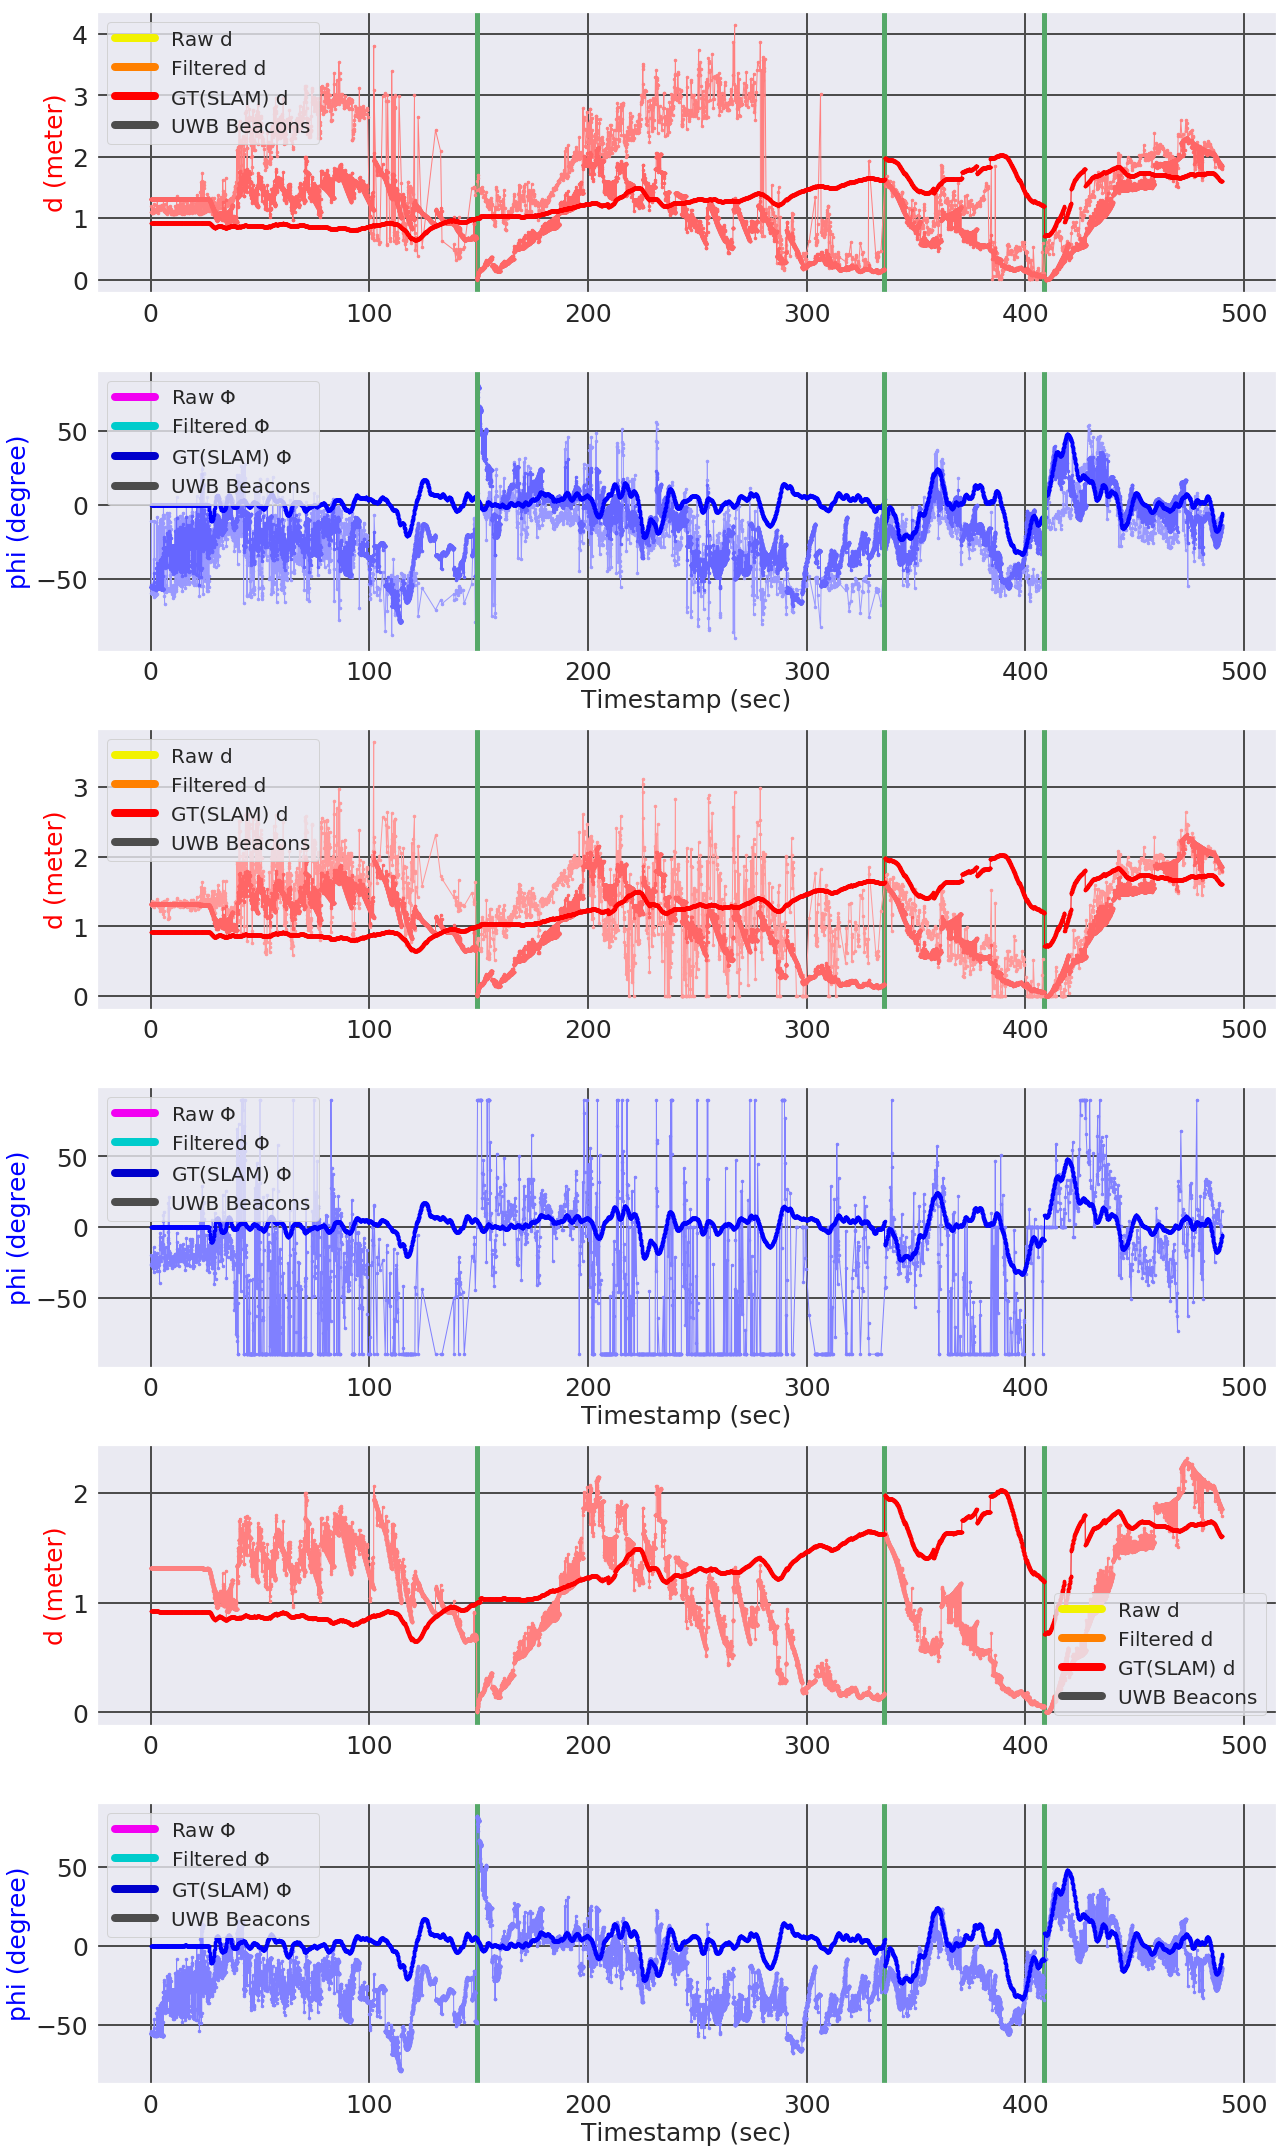

('Mean Error d', 0.9138644710120291)
('Mean Error phi', 26.812055236634574)
('RMSE d', 1.1273740059834205)
('RMSE phi', 32.93410053011468)
('StD d', 0.6601695827505306)
('StD phi', 19.125079652523187)
('Min d', 0.0014572433639679083)
('Min phi', 0.005499385924139233)
('Max d', 2.922403632445937)
('Max phi', 89.05406495552475)
('Mean Error d_g', 0.6199903467917661)
('Mean Error phi_g', 42.05939041123959)
('RMSE d_g', 0.7556902889046588)
('RMSE phi_g', 54.06890977378136)
('StD d_g', 0.43206455840514424)
('StD phi_g', 33.97726714084341)
('Min d_g', 1.1541537364712084e-06)
('Min phi_g', 0.04001060941333279)
('Max d_g', 2.769007814595391)
('Max phi_g', 113.20588758426106)
('Mean Error d_pf', 0.559708158652211)
('Mean Error phi_pf', 21.811848059510304)
('RMSE d_pf', 0.672817230099978)
('RMSE phi_pf', 26.622262149154395)
('StD d_pf', 0.3733762207982159)
('StD phi_pf', 15.263948577191139)
('Min d_pf', 0.0001350353091174039)
('Min phi_pf', 0.01412572231804976)
('Max d_pf', 1.8177702221006522)
(

In [90]:
dt_max = 0.1
draw_d_phi = {}

for filename in filenames:

    filename_p = 'data/jackal_ranges_' + filename + '.yaml'
    
    gt_filename = 'data/' + filename + '.yaml'
            
    print('New file: ',filename_p)
    print('New GT file: ',gt_filename)
       
    # open the range file
    try:
        with open(filename_p) as dis_file:
            all_data = yaml.load(dis_file)
            r_list = all_data['data']
            timestamps = all_data['timestamp'][guid_path[0]]
            start_time = all_data['start_time']['secs'] + all_data['start_time']['nsecs']*1e-9

            joints = all_data['joint']
            joint_stamps = all_data['joint_stamp']
            
            joint_stamps = np.array(joint_stamps)
            
            odom_x = np.array(all_data['odom_x'], dtype=np.float64)
            odom_theta = np.array(all_data['odom_theta'], dtype=np.float64)
            odom_stamps = np.array(all_data['odom_stamp'], dtype=np.float64)
            
            del all_data
    except IOError:
        print("No such file", filename_p)
        continue
    
    # open the ground truth file
    try:
        with open(gt_filename) as dis_file:
            all_data = yaml.load(dis_file)
            pos_list = all_data['data']
            #timestamp = all_data['start_time']
            start_time_slam = all_data['start_time']['secs'] + all_data['start_time']['nsecs']*1e-9

            pos_list['x'] = np.array(pos_list['x'], dtype=np.float64)
            pos_list['y'] = np.array(pos_list['y'], dtype=np.float64)
            pos_list['timestamp'] = np.array(pos_list['timestamp'], dtype=np.float64)
            
            del all_data
    except IOError:
        print("No such file", gt_filename)
        continue
    
    dt = start_time_slam - start_time
    pos_list['timestamp'] = pos_list['timestamp'] + dt
    
    f, axes = plt.subplots(nrows = 6, ncols = 1, figsize=(18,30))
    guid_sec = 0
    mds_r_key = ['bb', 'bf', 'fb', 'ff']
    mds_r = {}
    for k in mds_r_key:
        mds_r[k] = {}
        mds_r[k]['r'] = None
        mds_r[k]['t'] = None
    mds_flag = False
    joint = None
    anc_len = None
    draw_d_phi[filename] = None
    anchor_stamp = np.array([])
    errors = None
    pf = None
    odom_i = 0
    
    # truncate useless rosbag
    end_t = timestamps[-1]
    if filename == '0112_1153':
        end_t = 490.
    
    for i in range(len(timestamps)):
        
        if timestamps[i] > end_t:
            break
        
        
        # check change anchor
        if guid_sec < len(guid_path)-2:
            if r_list['back_left'][guid_path[guid_sec+2]][i] !=0 or r_list['front_right'][guid_path[guid_sec+2]][i] !=0:
                guid_sec += 1
                mds_r['bb'] = mds_r['bf']
                mds_r['fb'] = mds_r['ff']
                mds_r['bf']['r'] = None
                mds_r['bf']['t'] = None
                mds_r['ff']['r'] = None
                mds_r['ff']['t'] = None
                #print("change", guid_sec)
                anchor_stamp = np.append(anchor_stamp, timestamps[i])
                pf = None
        if guid_sec > 0:
            if r_list['back_left'][guid_path[guid_sec-1]][i] !=0 or r_list['front_right'][guid_path[guid_sec-1]][i] !=0:
                guid_sec -= 1
                mds_r['bf'] = mds_r['bb']
                mds_r['ff'] = mds_r['fb']
                mds_r['bb']['r'] = None
                mds_r['bb']['t'] = None
                mds_r['fb']['r'] = None
                mds_r['fb']['t'] = None
                #print("change", guid_sec)
                anchor_stamp = anchor_stamp[:-1]
        
                
        # check if had range
        this_r = {}
        this_r['bb'] = r_list['back_left'][guid_path[guid_sec]][i]
        this_r['bf'] = r_list['back_left'][guid_path[guid_sec+1]][i]
        this_r['fb'] = r_list['front_right'][guid_path[guid_sec]][i]
        this_r['ff'] = r_list['front_right'][guid_path[guid_sec+1]][i]
        
        # get stick length and height
        joint = joints[np.argmax(joint_stamps > timestamps[i])-1]
        j_ang = joint + math.pi
        dh_b = 0.3 + -0.05 + stick_l * math.cos(j_ang)
        dh_f = 0.5
        r_tag_points[0,0] = -0.14 +(stick_l * math.sin(j_ang))
        
        for k in mds_r_key:
            if this_r[k] != 0:

                if k[0] == 'b': # ranging from robot back tag
                    if this_r[k] * 0.001 > dh_b:
                        mds_r[k]['r'] = math.sqrt((this_r[k] * 0.001)**2 - dh_b**2)
                    else:
                        mds_r[k]['r'] = 0.1 # give a small value if almost arrive
                if k[0] == 'f': # ranging from robot front tag
                    if this_r[k] * 0.001 > dh_f:
                        mds_r[k]['r'] = math.sqrt((this_r[k] * 0.001)**2 - dh_f**2)
                    else:
                        mds_r[k]['r'] = 0.1 # give a small value if almost arrive
                        
                mds_r[k]['r'] = this_r[k] * 0.001
                mds_r[k]['t'] = timestamps[i]
        
        # check if all range is here
        if None not in [mds_r['bb']['r'], mds_r['bf']['r'], mds_r['fb']['r'], mds_r['ff']['r']]:
            mds_flag = True
            anc_len = guid_len[guid_sec]
            
            # check if dt < dt_max
            for k in mds_r_key:
                if timestamps[i] - mds_r[k]['t'] > dt_max:
                    mds_r[k]['r'] = None
                    mds_r[k]['t'] = None
                    mds_flag = False
        
        ## add ground truth from slam ##
        ## and initialized errors ##
        if draw_d_phi[filename] is None:
            draw_d_phi[filename] = {}
            draw_d_phi[filename]['t'] = np.array([])
            draw_d_phi[filename]['d'] = np.array([])
            draw_d_phi[filename]['phi'] = np.array([])
            draw_d_phi[filename]['d_g'] = np.array([])
            draw_d_phi[filename]['phi_g'] = np.array([])
            draw_d_phi[filename]['t_pf'] = np.array([])
            draw_d_phi[filename]['d_pf'] = np.array([])
            draw_d_phi[filename]['phi_pf'] = np.array([])
            draw_d_phi[filename]['t_gt'] = np.array([])
            draw_d_phi[filename]['d_gt'] = np.array([])
            draw_d_phi[filename]['phi_gt'] = np.array([])
            
            errors = {}
            errors['d'] = np.array([])
            errors['d_g'] = np.array([])
            errors['d_pf'] = np.array([])
            errors['phi'] = np.array([])
            errors['phi_g'] = np.array([])
            errors['phi_pf'] = np.array([])
        
        gt_i = np.argmax(pos_list['timestamp']>=timestamps[i])
        gt_stamp = pos_list['timestamp'][gt_i]
        
        add_gt = False
        if len(draw_d_phi[filename]['t_gt']) == 0:
            add_gt = True
        else:
            if gt_stamp > draw_d_phi[filename]['t_gt'][-1]:
                add_gt = True
        
        if add_gt:
            draw_d_phi[filename]['t_gt'] = np.append(draw_d_phi[filename]['t_gt'], gt_stamp)
            px = pos_list['x'][gt_i]
            py = pos_list['y'][gt_i]
            ptheta = pos_list['theta'][gt_i]
            
            anc_last_x = guid_anchor_pos[guid_sec][0]
            anc_last_y = guid_anchor_pos[guid_sec][1]
            anc_next_x = guid_anchor_pos[guid_sec+1][0]
            anc_next_y = guid_anchor_pos[guid_sec+1][1]
            anc_theta = math.atan2(anc_next_y-anc_last_y, anc_next_x-anc_last_x)
        
            phi_gt = ptheta - anc_theta
            d_gt = math.fabs((anc_next_x-anc_last_x)*(anc_last_y-py)-(anc_last_x-px)*(anc_next_y-anc_last_y)) / math.sqrt((anc_next_x-anc_last_x)**2+(anc_next_y-anc_last_y)**2)
        
            draw_d_phi[filename]['d_gt'] = np.append(draw_d_phi[filename]['d_gt'], d_gt)
            draw_d_phi[filename]['phi_gt'] = np.append(draw_d_phi[filename]['phi_gt'], math.degrees(phi_gt))
        
        if pf is not None:
            while odom_stamps[odom_i+1] <= timestamps[i]:
                d_pf, phi_pf = pf.pf_localization([[odom_x[odom_i]], [odom_theta[odom_i]]])
                draw_d_phi[filename]['t_pf'] = np.append(draw_d_phi[filename]['t_pf'], odom_stamps[odom_i])
                draw_d_phi[filename]['d_pf'] = np.append(draw_d_phi[filename]['d_pf'], d_pf)
                draw_d_phi[filename]['phi_pf'] = np.append(draw_d_phi[filename]['phi_pf'], math.degrees(phi_pf))
                odom_i += 1
        
        ###################################
        
        if mds_flag:
            
            ### mds #######
            r_matrix = np.array([[0, np.linalg.norm(r_tag_points[0]-r_tag_points[1])],
                        [np.linalg.norm(r_tag_points[0]-r_tag_points[1]), 0]])
            
            this_rb = [mds_r['bb']['r'], mds_r['fb']['r']]
            this_rf = [mds_r['bf']['r'], mds_r['ff']['r']]
            r_matrix = np.vstack((r_matrix, this_rb))
            r_matrix = np.vstack((r_matrix, this_rf))
            this_rb = np.append(this_rb, [0, anc_len])
            this_rf = np.append(this_rf, [anc_len, 0])
            r_matrix = np.hstack((r_matrix, np.resize(this_rb, (len(this_rb),1))))
            r_matrix = np.hstack((r_matrix, np.resize(this_rf, (len(this_rb),1))))

            model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
            # print(r_matrix)
            out = model.fit_transform(r_matrix)
            
            # Transform the output points
            def transform(bp, fp):
                last_pos = self.tag_pos[self.id_to_anc[self.last_tag]]
                next_pos = self.tag_pos[self.id_to_anc[self.next_tag]]
                v_anc = np.array(next_pos) - np.array(last_pos)
                ang_anc = math.atan2(v_anc[1], v_anc[0])
                v = fp-bp
                ang = math.atan2(v[1],v[0])
                d_ang = ang - ang_anc
                TM_pre = np.array([[1, 0, -last_pos[0]],
                            [0, 1, -last_pos[1]],
                            [0, 0, 1]])
                TM = np.array([[math.cos(d_ang),-math.sin(d_ang),bp[0]],
                            [math.sin(d_ang),math.cos(d_ang),bp[1]],
                            [0, 0, 1]])
                TM = np.linalg.inv(np.dot(TM, TM_pre))
                # print TM
                return TM
            def transform_r(bp, fp):
                v = fp-bp
                vo = np.array(r_tag_points[1]) - np.array(r_tag_points[0])
                ang = math.atan2(v[1],v[0]) - math.atan2(vo[1],vo[0])
                TM = np.array([[math.cos(ang),-math.sin(ang),bp[0]],
                            [math.sin(ang),math.cos(ang),bp[1]],
                            [0, 0, 1]])
                TM = np.linalg.inv(TM)
                # print TM
                return TM

            # Check if the MDS results is flipped
            # Very Important!!!!!!!
            flip = check_flip(out, True)
            if flip:
                out[:, 0] = -1*out[:, 0]

            #if self.anchor_frame == 'base_link':
            #    TM = transform_r(out[-4],out[-3]) # out[-4]: robot back_left, out[-3]: robot front_right
            #else:
            #    TM = transform(out[-2],out[-1]) # out[-2]: anchor back, out[-1]: anchor front
            
            TM = transform_r(out[-4],out[-3])
            out_modified = np.dot(TM[:2, :2], out[-4:][-4:].T).T + TM[:2,2]
            # print(out_modified)
            out_modified[:,0] = out_modified[:,0] + r_tag_points[0,0]
            # print(out_modified)

            ## d and phi
            x2 = out_modified[-1][0]
            x1 = out_modified[-2][0]
            y2 = out_modified[-1][1]
            y1 = out_modified[-2][1]
            line = np.polyfit([x2, x1], [y2, y1], 1)
            d = math.fabs(line[1]) / np.linalg.norm([line[0], -1])
            phi = math.atan2((y2-y1), (x2-x1)) * -1
            
            #print(timestamps[i], d, math.degrees(phi))
            ################
            
            ### geography #######
            
            s1 = (mds_r['ff']['r'] + mds_r['fb']['r'] + anc_len)/2
            if s1 < anc_len or s1 < mds_r['ff']['r'] or s1 < mds_r['fb']['r']:
                d1 = 0
            else:
                d1 = 2*math.sqrt(s1*(s1-mds_r['ff']['r'])*(s1-mds_r['fb']['r'])*(s1-anc_len))/anc_len
            s2 = (mds_r['bf']['r'] + mds_r['bb']['r'] + anc_len)/2
            if s2 < anc_len or s2 < mds_r['bf']['r'] or s2 < mds_r['bb']['r']:
                d2 = 0
            else:
                d2 = 2*math.sqrt(s2*(s2-mds_r['bf']['r'])*(s2-mds_r['bb']['r'])*(s2-anc_len))/anc_len

            # get d, phi relative to the lane
            d_g = (d1+d2)/2
            sin_v = (d1-d2)/np.linalg.norm(r_tag_points[0]-r_tag_points[1])
            if sin_v > 1:
                sin_v = 1
            if sin_v < -1:
                sin_v = -1
            phi_g = math.asin(sin_v)
            heading = (mds_r['fb']['r']+mds_r['bf']['r'])-(mds_r['ff']['r']-mds_r['bb']['r'])
            if heading < 0: # the robot is heading back
                phi_g = math.pi - phi_g
                if phi_g > math.pi:
                    phi_g -= 2*math.pi
            #######################
            
            if d < 10 and d_g < 10 and -90 <= math.degrees(phi) <=90 and -90 <= math.degrees(phi) <=90:
                # initialize with first d phi
                if pf is None:
                    pf = ParticleFilter(d_init=d_g, phi_init=phi)
                    odom_i = np.argmax(odom_stamps>=timestamps[i])
                    draw_d_phi[filename]['t_pf'] = np.append(draw_d_phi[filename]['t_pf'], timestamps[i])
                    d_pf=d_g 
                    phi_pf=phi
                else:
                    d_pf, phi_pf = pf.pf_localization([[odom_x[odom_i]], [odom_theta[odom_i]]], [[d_g],[phi]])
                    draw_d_phi[filename]['t_pf'] = np.append(draw_d_phi[filename]['t_pf'], odom_stamps[odom_i])
                    odom_i += 1
                
                draw_d_phi[filename]['t'] = np.append(draw_d_phi[filename]['t'], timestamps[i])
                draw_d_phi[filename]['d'] = np.append(draw_d_phi[filename]['d'], d)
                draw_d_phi[filename]['phi'] = np.append(draw_d_phi[filename]['phi'], math.degrees(phi))
                draw_d_phi[filename]['d_g'] = np.append(draw_d_phi[filename]['d_g'], d_g)
                draw_d_phi[filename]['phi_g'] = np.append(draw_d_phi[filename]['phi_g'], math.degrees(phi_g))
                draw_d_phi[filename]['d_pf'] = np.append(draw_d_phi[filename]['d_pf'], d_pf)
                draw_d_phi[filename]['phi_pf'] = np.append(draw_d_phi[filename]['phi_pf'], math.degrees(phi_pf))
            
                errors['d'] = np.append(errors['d'], math.fabs(d-draw_d_phi[filename]['d_gt'][-1]))
                errors['d_g'] = np.append(errors['d_g'], math.fabs(d_g-draw_d_phi[filename]['d_gt'][-1]))
                errors['d_pf'] = np.append(errors['d_pf'], math.fabs(d_pf-draw_d_phi[filename]['d_gt'][-1]))
                errors['phi'] = np.append(errors['phi'], math.fabs(math.degrees(phi)-draw_d_phi[filename]['phi_gt'][-1]))
                errors['phi_g'] = np.append(errors['phi_g'], math.fabs(math.degrees(phi_g)-draw_d_phi[filename]['phi_gt'][-1]))
                errors['phi_pf'] = np.append(errors['phi_pf'], math.fabs(math.degrees(phi_pf)-draw_d_phi[filename]['phi_gt'][-1]))
             
            # initialize
            for k in mds_r_key:
                mds_r[k] = {}
                mds_r[k]['r'] = None
                mds_r[k]['t'] = None
            mds_flag = False
            joint = None
            anc_len = None
    
    for st in anchor_stamp:
        axes[0].axvline(st, linewidth=5, color='g')
    axes[0].plot(draw_d_phi[filename]['t'], draw_d_phi[filename]['d'], color=[1, 0.5, 0.5], marker='.', linewidth=1, markersize=5)
    axes[0].plot(draw_d_phi[filename]['t_pf'], draw_d_phi[filename]['d_pf'], color=[1, 0.4, 0.4], marker='.', linewidth=1, markersize=5)
    axes[0].plot(draw_d_phi[filename]['t_gt'], draw_d_phi[filename]['d_gt'], color=[1, 0, 0], marker='.', linewidth=1, markersize=5)
    axes[0] = ax_init_d(axes[0], [1, 0, 0])
    for st in anchor_stamp:
        axes[1].axvline(st, linewidth=5, color='g')
    axes[1].plot(draw_d_phi[filename]['t'], draw_d_phi[filename]['phi'], color=[0.6, 0.6, 1], marker='.', linewidth=1, markersize=5)
    axes[1].plot(draw_d_phi[filename]['t_pf'], draw_d_phi[filename]['phi_pf'], color=[0.4, 0.4, 1], marker='.', linewidth=1, markersize=5)
    axes[1].plot(draw_d_phi[filename]['t_gt'], draw_d_phi[filename]['phi_gt'], color=[0, 0, 1], marker='.', linewidth=1, markersize=5)
    axes[1] = ax_init_phi(axes[1], [0, 0, 1])
    
    for st in anchor_stamp:
        axes[2].axvline(st, linewidth=5, color='g')
    axes[2].plot(draw_d_phi[filename]['t'], draw_d_phi[filename]['d_g'], color=[1, 0.6, 0.6], marker='.', linewidth=1, markersize=5)
    axes[2].plot(draw_d_phi[filename]['t_pf'], draw_d_phi[filename]['d_pf'], color=[1, 0.4, 0.4], marker='.', linewidth=1, markersize=5)
    axes[2].plot(draw_d_phi[filename]['t_gt'], draw_d_phi[filename]['d_gt'], color=[1, 0, 0], marker='.', linewidth=1, markersize=5)
    axes[2] = ax_init_d(axes[2], [1, 0, 0])
    for st in anchor_stamp:
        axes[1].axvline(st, linewidth=5, color='g')
    axes[3].plot(draw_d_phi[filename]['t'], draw_d_phi[filename]['phi_g'], color=[0.5, 0.5, 1], marker='.', linewidth=1, markersize=5)
    axes[3].plot(draw_d_phi[filename]['t_gt'], draw_d_phi[filename]['phi_gt'], color=[0, 0, 1], marker='.', linewidth=1, markersize=5)
    axes[3] = ax_init_phi(axes[3], [0, 0, 1])
    
    for st in anchor_stamp:
        axes[4].axvline(st, linewidth=5, color='g')
    axes[4].plot(draw_d_phi[filename]['t_pf'], draw_d_phi[filename]['d_pf'], color=[1, 0.5, 0.5], marker='.', linewidth=1, markersize=5)
    axes[4].plot(draw_d_phi[filename]['t_gt'], draw_d_phi[filename]['d_gt'], color=[1, 0, 0], marker='.', linewidth=1, markersize=5)
    axes[4] = ax_init_d(axes[4], [1, 0, 0])
    for st in anchor_stamp:
        axes[5].axvline(st, linewidth=5, color='g')
    axes[5].plot(draw_d_phi[filename]['t_pf'], draw_d_phi[filename]['phi_pf'], color=[0.5, 0.5, 1], marker='.', linewidth=1, markersize=5)
    axes[5].plot(draw_d_phi[filename]['t_gt'], draw_d_phi[filename]['phi_gt'], color=[0, 0, 1], marker='.', linewidth=1, markersize=5)
    axes[5] = ax_init_phi(axes[5], [0, 0, 1])
    
    del r_list
    del timestamps
    del joints
    del joint_stamps
    
    f.tight_layout()
    plt.show()
    
    for me in ['', '_g', '_pf']:
        print("Mean Error d"+me, np.mean(errors['d'+me]))
        print("Mean Error phi"+me, np.mean(errors['phi'+me]))
        print("RMSE d"+me, np.sqrt(np.mean(errors['d'+me]**2)))
        print("RMSE phi"+me, np.sqrt(np.mean(errors['phi'+me]**2)))
        print("StD d"+me, np.std(errors['d'+me]))
        print("StD phi"+me, np.std(errors['phi'+me]))
        print("Min d"+me, np.min(errors['d'+me]))
        print("Min phi"+me, np.min(errors['phi'+me]))
        print("Max d"+me, np.max(errors['d'+me]))
        print("Max phi"+me, np.max(errors['phi'+me]))
    
    print "=================================================="

    

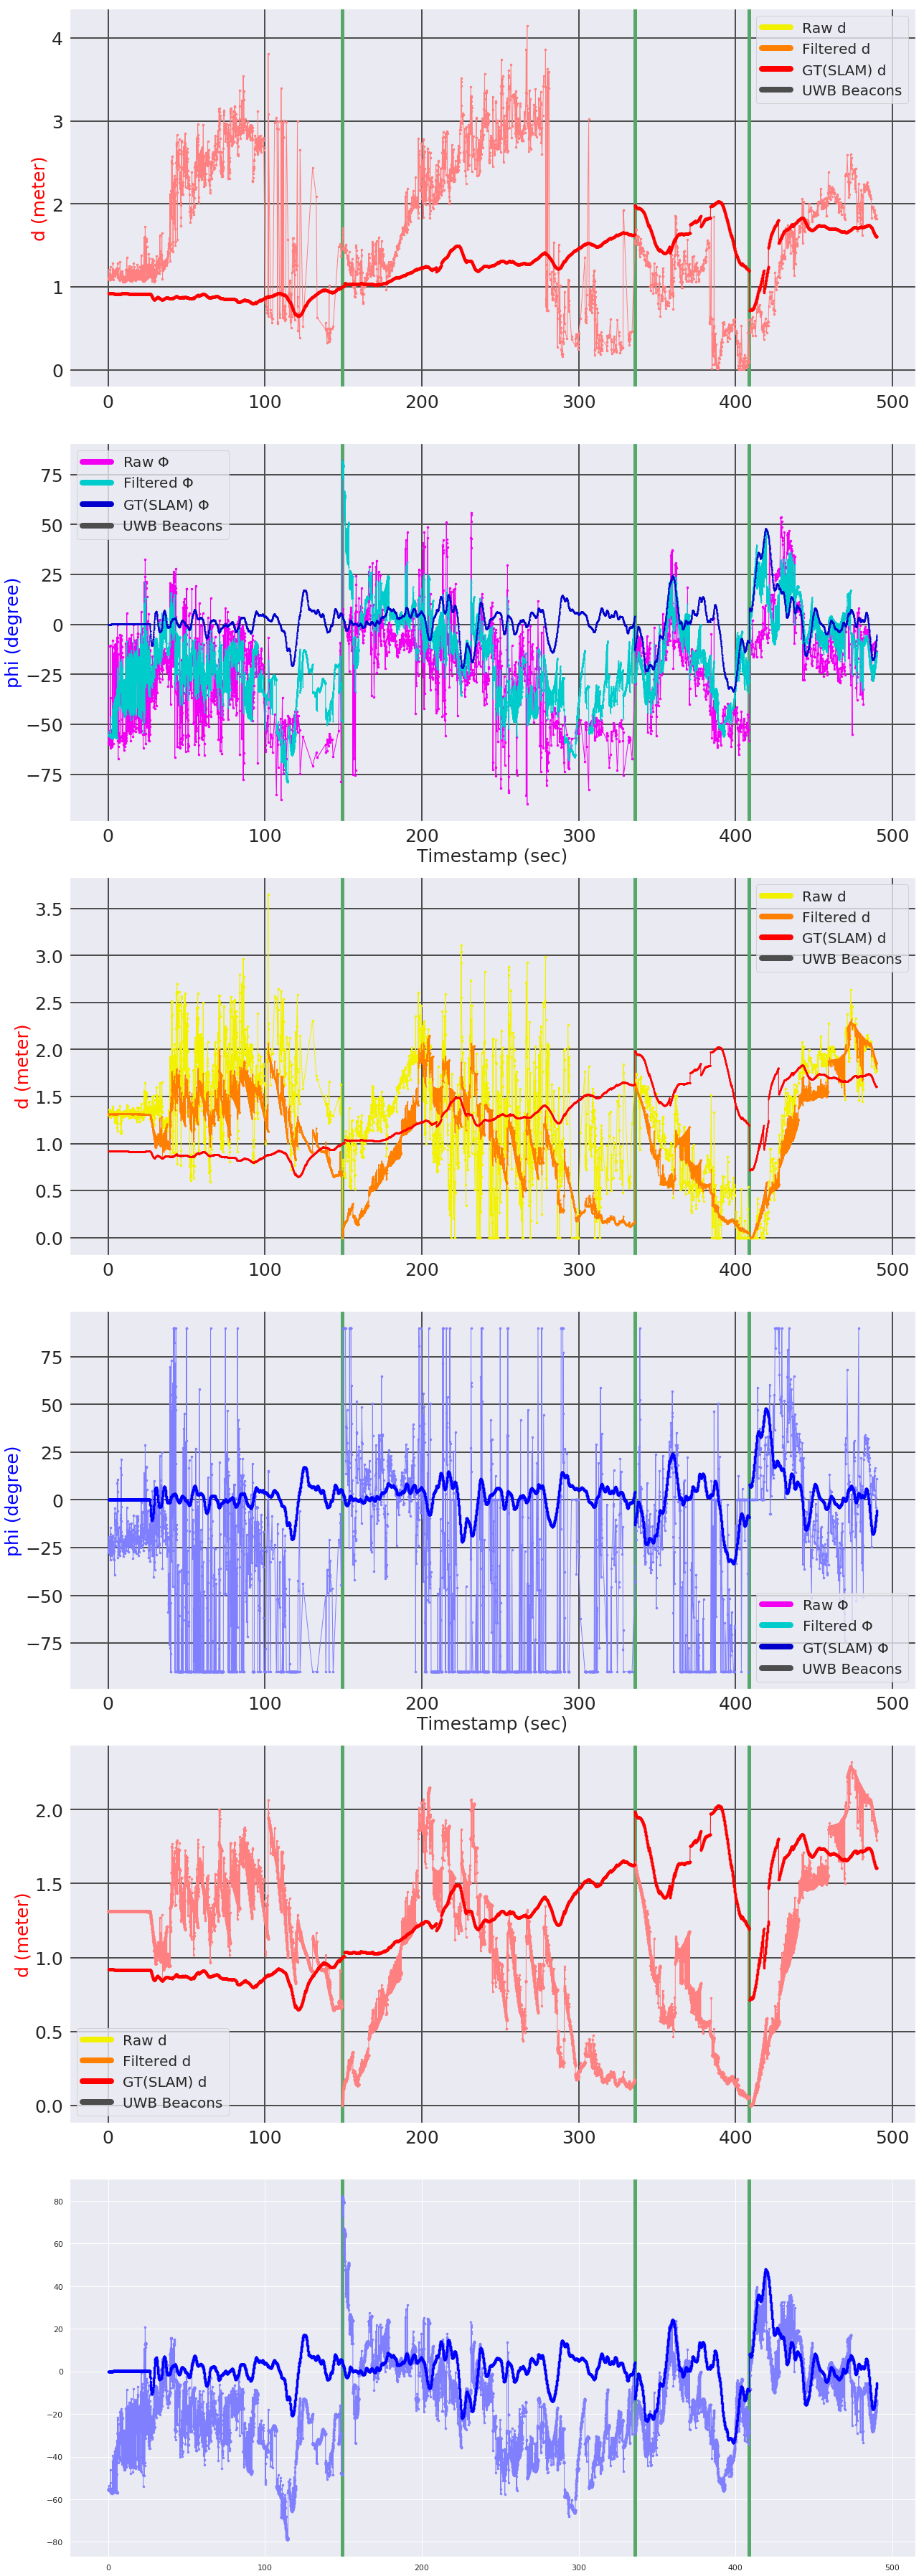

In [91]:
f, axes = plt.subplots(nrows = 6, ncols = 1, figsize=(18,50))

for st in anchor_stamp:
    axes[0].axvline(st, linewidth=5, color='g')
axes[0].plot(draw_d_phi['0112_1153']['t'], draw_d_phi['0112_1153']['d'], color=[1, 0.5, 0.5], marker='.', linewidth=1, markersize=5)
axes[0].plot(draw_d_phi['0112_1153']['t_gt'], draw_d_phi['0112_1153']['d_gt'], color=[1, 0, 0], marker='.', linewidth=1, markersize=5)
axes[0] = ax_init_d(axes[0], [1, 0, 0])
for st in anchor_stamp:
    axes[1].axvline(st, linewidth=5, color='g')
axes[1].plot(draw_d_phi['0112_1153']['t'], draw_d_phi['0112_1153']['phi'], color=[0.95, 0, 0.95], marker='.', linewidth=1, markersize=5)
axes[1].plot(draw_d_phi['0112_1153']['t_pf'], draw_d_phi['0112_1153']['phi_pf'], color=[0, 0.8, 0.8], marker='.', linewidth=1, markersize=2)
axes[1].plot(draw_d_phi['0112_1153']['t_gt'], draw_d_phi['0112_1153']['phi_gt'], color=[0, 0, 0.8], marker='.', linewidth=1, markersize=2)
axes[1] = ax_init_phi(axes[1], [0, 0, 1])

for st in anchor_stamp:
    axes[2].axvline(st, linewidth=5, color='g')
axes[2].plot(draw_d_phi['0112_1153']['t'], draw_d_phi['0112_1153']['d_g'], color=[0.95, 0.95, 0], marker='.', linewidth=1, markersize=5)
axes[2].plot(draw_d_phi['0112_1153']['t_pf'], draw_d_phi['0112_1153']['d_pf'], color=[1, 0.5, 0], marker='.', linewidth=1, markersize=2)
axes[2].plot(draw_d_phi['0112_1153']['t_gt'], draw_d_phi['0112_1153']['d_gt'], color=[1, 0., 0], marker='.', linewidth=1, markersize=2)
axes[2] = ax_init_d(axes[2], [1, 0, 0])
for st in anchor_stamp:
    axes[3].axvline(st, linewidth=5, color='g')
axes[3].plot(draw_d_phi['0112_1153']['t'], draw_d_phi['0112_1153']['phi_g'], color=[0.5, 0.5, 1], marker='.', linewidth=1, markersize=5)
axes[3].plot(draw_d_phi['0112_1153']['t_gt'], draw_d_phi['0112_1153']['phi_gt'], color=[0, 0, 1], marker='.', linewidth=1, markersize=5)
axes[3] = ax_init_phi(axes[3], [0, 0, 1])

for st in anchor_stamp:
    axes[4].axvline(st, linewidth=5, color='g')
axes[4].plot(draw_d_phi['0112_1153']['t_pf'], draw_d_phi['0112_1153']['d_pf'], color=[1, 0.5, 0.5], marker='.', linewidth=1, markersize=5)
axes[4].plot(draw_d_phi['0112_1153']['t_gt'], draw_d_phi['0112_1153']['d_gt'], color=[1, 0, 0], marker='.', linewidth=1, markersize=5)
axes[4] = ax_init_d(axes[4], [1, 0, 0])
for st in anchor_stamp:
    axes[5].axvline(st, linewidth=5, color='g')
axes[5].plot(draw_d_phi['0112_1153']['t_pf'], draw_d_phi['0112_1153']['phi_pf'], color=[0.5, 0.5, 1], marker='.', linewidth=1, markersize=5)
axes[5].plot(draw_d_phi['0112_1153']['t_gt'], draw_d_phi['0112_1153']['phi_gt'], color=[0, 0, 1], marker='.', linewidth=1, markersize=5)

f.tight_layout()
plt.show()